In [ ]:
!pip install -U transformers huggingface_hub -q

# **Approach 1: Direct Whisper Inference**

In this approach, we'll perform inference using the Whisper model on the test dataset with manually specified conditions to establish a baseline.

## **Import Required Libraries**

In [ ]:
import os
import torch
import librosa
from transformers import pipeline
from tqdm.notebook import tqdm
import pandas as pd
import os
from pathlib import Path
from catboost import CatBoostClassifier
import json
from sklearn.model_selection import train_test_split
import os
import json
import torch
import torchaudio
import numpy as np
import pandas as pd
from transformers import AutoProcessor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from transformers import AutoModelForSpeechSeq2Seq
import os
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import torch

## **Define Inference Functions**

In [2]:
def load_audio(path: str, target_sr: int = 16000):
    """
    Read wav and resample to target_sr (if needed).
    Returns numpy array (float32), mono.
    """
    audio, sr = librosa.load(path, sr=target_sr, mono=True)
    # librosa returns float32 in interval [-1,1]
    return audio, target_sr

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # your device

In [4]:
def transcribe_wav(
    wav_path: str,
    model_id: str = "openai/whisper-large-v3-turbo",
    device: int | str | None = None,
    chunk_length_s: float | None = None,
    **pipeline_kwargs
):
    """
    transcribe_wav(...) -> dict
    Returns pipeline's response (usually dict with 'text' etc.).
    If chunk_length_s — audio will split on batches and transcribate in order.
    """
    if device is None:
        device = 0 if torch.cuda.is_available() else -1

    asr = pipeline(
        "automatic-speech-recognition",
        model=model_id,
        device=device,
        **pipeline_kwargs
    )

    
    audio, sr = load_audio(wav_path, target_sr=16000)

    if not chunk_length_s:
        out = asr(audio, chunk_length_s=None)
        return out

    samples_per_chunk = int(chunk_length_s * sr)
    texts = []
    for i in range(0, len(audio), samples_per_chunk):
        chunk = audio[i : i + samples_per_chunk]
        if len(chunk) == 0:
            continue
        chunk_out = asr(chunk, chunk_length_s=None)
        if isinstance(chunk_out, dict):
            texts.append(chunk_out.get("text", "").strip())
        else:
            texts.append(str(chunk_out).strip())
    full_text = " ".join(t for t in texts if t)
    return {"text": full_text}

## **Test Inference on a Single Audio Sample**

In [5]:
WAV_PATH = "/kaggle/input/vseross-2-audio/wav_test/0000219778122723066859323624505982384475.wav"
result = transcribe_wav(WAV_PATH, device=device)
text = result.get("text")
print(text)

Device set to use cuda
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


 Дату указываю внизу. Мы с вами встретимся


## **Run Inference on All Test Samples**

### **Modified Function for Batch Processing**

We'll modify the transcription function to process all audio files in a directory.

In [24]:
def transcribe_wav(
    audio_path: str,
    model_id: str = "openai/whisper-large-v3-turbo",
    device: int | str | None = None,
    chunk_length_s: float | None = None,
    **pipeline_kwargs
):
    """
    transcribe_wav(...) -> dict
    Returns pipeline's response (usually dict with 'text' etc.).
    If chunk_length_s — audio will split on batches and transcribate in order.
    """
    if device is None:
        device = 0 if torch.cuda.is_available() else -1

    asr = pipeline(
        "automatic-speech-recognition",
        model=model_id,
        device=device,
        **pipeline_kwargs
    )


    data = []
    for wav_path in tqdm(os.listdir(audio_path), desc='Inferencing'):
        wav_path = Path(audio_path) / wav_path
        audio, sr = load_audio(wav_path, target_sr=16000)
    
        samples_per_chunk = int(chunk_length_s * sr)
        texts = []
        for i in range(0, len(audio), samples_per_chunk):
            chunk = audio[i : i + samples_per_chunk]
            if len(chunk) == 0:
                continue
            chunk_out = asr(chunk, chunk_length_s=None)
            if isinstance(chunk_out, dict):
                texts.append(chunk_out.get("text", "").strip())
            else:
                texts.append(str(chunk_out).strip())
        full_text = " ".join(t for t in texts if t)
        data.append({
            "path": wav_path,
            "text": full_text
        })

    return pd.DataFrame(data)

In [25]:
app_1 = transcribe_wav(audio_path="/kaggle/input/vseross-2-audio/wav_test", device=device, chunk_length_s=4000)

In [ ]:
app_1['target'] = app_1['text'].apply(lambda x: 1 if 'не слыш' in x else 0)

In [ ]:
app_1.to_csv('approach_1.csv', index=False)

# **Approach 2: CatBoost Text Classification**

In the previous approach, we used a simple rule-based method:
```py
app_1['text'].apply(lambda x: 1 if 'не слыш' in x else 0)
```

This approach lacks accuracy. Instead, we'll train a CatBoost classifier to better classify the transcribed texts.

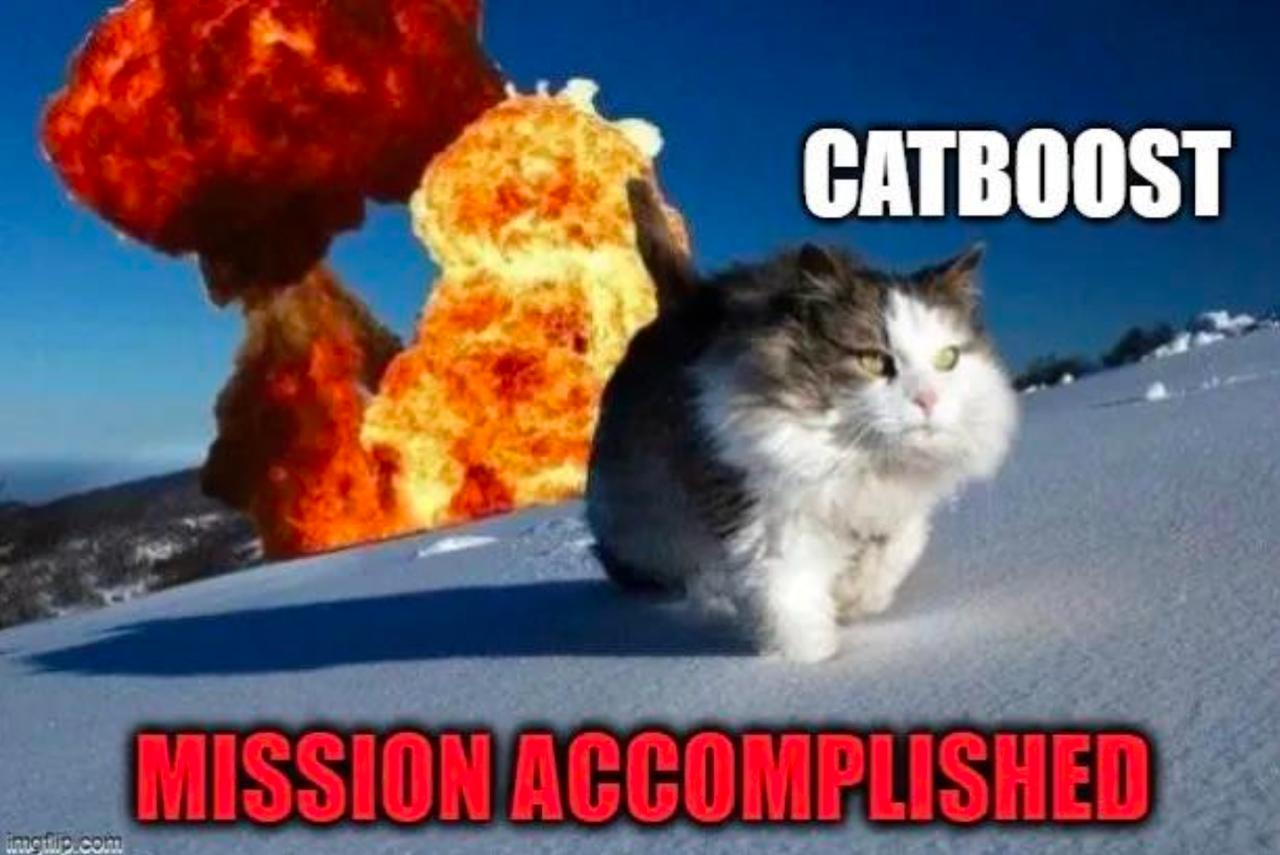

In [ ]:
train_df = transcribe_wav(audio_path="/kaggle/input/vseross-2-audio/wav_train", device=device, chunk_length_s=4000)
test_df = app_1.copy()

In [27]:
with open('/kaggle/input/train-json-audio-vseross/word_bounds.json', 'rb') as file:
    word_bounds = json.load(file)

In [30]:
trues = list(word_bounds.keys()) # get targets for train

In [ ]:
train_df['target'] = train_df['path'].apply(lambda x: 1 if x.split('/')[-1].split('.')[0] in trues else 0)

### **Train CatBoost Classifier**

In [ ]:
X = train_df[['text']]
y = train_df['target']

In [ ]:
cbm = CatBoostClassifier(
    10000,
    text_features=['text'],
    eval_metric='Accuracy',
    verbose=1000,
)
cbm.fit(X, y)

In [ ]:
test_df['target'] = cbm.predict(test_df[['text']])

In [ ]:
test_df.to_csv('approach_2.csv', index=False)

# **Approach 3: Fine-tuning Whisper for Classification or Scale to AGI???**

The previous approach achieved the best score without additional training. Now, we'll fine-tune the Whisper-medium model on the training data for improved performance.

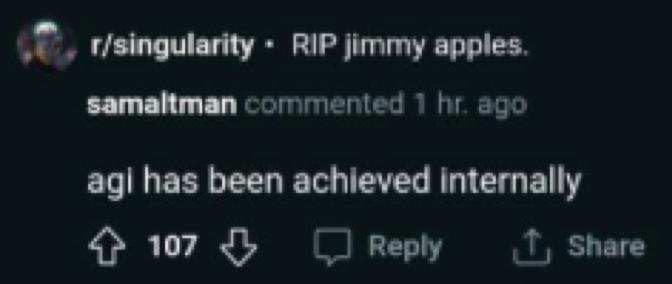

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### **Configuration Parameters**

In [ ]:
train_audio_dir = '/kaggle/input/vseross-2-audio/wav_train'
train_json_file = '/kaggle/input/train-json-audio-vseross/word_bounds.json'

test_audio_dir = '/kaggle/input/vseross-2-audio/wav_test'

model_id = "openai/whisper-medium"

num_workers = 0
batch_size = 4

n_splits = 5
num_epochs = 1

encoder_lr = 1e-5
head_lr = 3e-4

### **Load and Prepare Training Data**

In [ ]:
with open(train_json_file) as file:
    train_data = json.load(file)

train_df = pd.DataFrame({'id': [file_name[:file_name.rfind('.')] for file_name in os.listdir(train_audio_dir)]})
train_df['label'] = train_df['id'].apply(lambda id: id in train_data).astype(int)
train_df['audio_path'] = train_audio_dir + train_df['id'] + '.wav'
train_df.head()

In [ ]:
splitter = StratifiedKFold(n_splits=n_splits)

### **Custom Dataset Class**

In [ ]:
class AudioClassificationDataset(Dataset):
    processor = AutoProcessor.from_pretrained(model_id)
    
    def __init__(self, audio_paths, labels=None, sampling_rate=16_000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.sampling_rate = sampling_rate
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sampling_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sampling_rate)

        inputs = self.processor(
            waveform.squeeze(0),
            sampling_rate=self.sampling_rate,
            return_tensors="pt"
        )

        inputs_dict = {"input_features": inputs.input_features.squeeze(0)}
        if self.labels is not None:
            inputs_dict["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return inputs_dict

### **Audio Classification Model Architecture**

In [ ]:
class AudioClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModelForSpeechSeq2Seq.from_pretrained(model_id).model.encoder  # только энкодер
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.encoder.layer_norm.normalized_shape[0], 2)
        )

    def forward(self, input_features, labels=None):
        outputs = self.encoder(input_features)
        hidden_states = outputs.last_hidden_state  # (batch, seq_len, hidden)
        
        # усредняем по времени (глобальный пуллинг)
        pooled = hidden_states.mean(dim=1)
        logits = self.head(pooled)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        
        return {"loss": loss, "logits": logits}

### **Training Loop with Cross-Validation**

In [ ]:
import os
from sklearn.metrics import f1_score
from tqdm.auto import tqdm
import torch

os.makedirs('models', exist_ok=True)

# Save
models = []
fit_results = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32

# Train
for i, (train_index, valid_index) in enumerate(splitter.split(train_df, train_df['label'])):
    print(f"Split: {i + 1}", end="\n\n")

    train_audio_paths_split, train_labels_split = train_df['audio_path'].values[train_index], train_df['label'].values[train_index]
    valid_audio_paths_split, valid_labels_split = train_df['audio_path'].values[valid_index], train_df['label'].values[valid_index]

    train_dataset = AudioClassificationDataset(train_audio_paths_split, train_labels_split)
    valid_dataset = AudioClassificationDataset(valid_audio_paths_split, valid_labels_split)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        num_workers=num_workers, 
        shuffle=True, 
        drop_last=True,
        pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        num_workers=num_workers, 
        shuffle=False, 
        drop_last=False,
        pin_memory=True
    )

    model = AudioClassificationModel()
    model.to(device=device, dtype=dtype)
    optimizer = torch.optim.Adam([
        {'params': model.encoder.parameters(), 'lr': encoder_lr},
        {'params': model.head.parameters(), 'lr': head_lr}
    ])
    
    fit_result = {
        'train_losses': [],
        'train_f1': [],
        'valid_losses': [],
        'valid_f1': []
    }

    for epoch in range(1, num_epochs + 1):
        # === TRAIN ===
        model.train()
        train_losses = []
        all_train_preds, all_train_targets = [], []
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
        
        for batch in progress_bar:
            input_features = batch['input_features'].to(device=device, dtype=dtype)
            labels = batch['labels'].to(device=device)

            optimizer.zero_grad()
            outputs = model(input_features, labels=labels)
            loss = outputs['loss']
            loss.backward()
            optimizer.step()

            preds = outputs['logits'].argmax(dim=1).detach().cpu().numpy()
            targets = labels.cpu().numpy()

            all_train_preds.extend(preds)
            all_train_targets.extend(targets)
            train_losses.append(loss.item())

            progress_bar.set_postfix(loss=loss.item())

        train_loss = sum(train_losses) / len(train_losses)
        train_f1 = f1_score(all_train_targets, all_train_preds, average='macro')
        fit_result['train_losses'].append(train_loss)
        fit_result['train_f1'].append(train_f1)
        print(f"Train loss: {train_loss:.4f} | F1 (macro): {train_f1:.4f}")

        # === VALID ===
        model.eval()
        valid_losses = []
        all_valid_preds, all_valid_targets = [], []

        progress_bar = tqdm(valid_loader, desc=f"Epoch {epoch} [Valid]")
        with torch.no_grad():
            for batch in progress_bar:
                input_features = batch['input_features'].to(device=device, dtype=dtype)
                labels = batch['labels'].to(device=device)

                outputs = model(input_features, labels=labels)
                loss = outputs['loss']

                preds = outputs['logits'].argmax(dim=1).detach().cpu().numpy()
                targets = labels.cpu().numpy()

                all_valid_preds.extend(preds)
                all_valid_targets.extend(targets)
                valid_losses.append(loss.item())

                progress_bar.set_postfix(loss=loss.item())

        valid_loss = sum(valid_losses) / len(valid_losses)
        valid_f1 = f1_score(all_valid_targets, all_valid_preds, average='macro')

        fit_result['valid_losses'].append(valid_loss)
        fit_result['valid_f1'].append(valid_f1)

        print(f"Valid loss: {valid_loss:.4f} | F1 (macro): {valid_f1:.4f}\n")

    fit_results.append(fit_result)
    models.append(model)
    
    path = f'models/split_{i + 1}.pt'
    torch.save(model.state_dict(), path)
    break

## **Generate Predictions on Test Set**

In [ ]:
class AudioTestDataset(Dataset):
    processor = AutoProcessor.from_pretrained(model_id)

    def __init__(self, audio_paths, sampling_rate=16_000):
        self.audio_paths = audio_paths
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        waveform, sr = torchaudio.load(audio_path)
        if sr != self.sampling_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sampling_rate)

        inputs = self.processor(
            waveform.squeeze(0),
            sampling_rate=self.sampling_rate,
            return_tensors="pt"
        )
        return {"input_features": inputs.input_features.squeeze(0), "id": os.path.basename(audio_path).replace('.wav','')}

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32
model = AudioClassificationModel()
model.to(device=device, dtype=dtype)
model.load_state_dict(torch.load('models/split_1.pt', map_location=device))
model.to(device, dtype=dtype)
model.eval();

In [ ]:
batch_size_test = 8

test_audio_paths = [os.path.join(test_audio_dir, f) for f in os.listdir(test_audio_dir) if f.endswith('.wav')]
test_loader = DataLoader(AudioTestDataset(test_audio_paths),
                         batch_size=batch_size_test, shuffle=False,
                         num_workers=num_workers, pin_memory=True)


In [ ]:
all_preds = []
all_ids = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Inference"):
        input_features = batch['input_features'].to(device=device, dtype=dtype)
        outputs = model(input_features)
        # DataParallel: берем mean по GPU, если есть
        logits = outputs['logits']
        preds = logits.argmax(dim=1).detach().cpu().numpy()

        all_preds.extend(preds)
        all_ids.extend(batch['id'])

In [ ]:
submission = pd.DataFrame({
    'id': all_ids,
    'label': all_preds
})

submission.to_csv(f'approach_3_{model_id}.csv', index=False)

# **Approach 4: Ensemble of Multiple Models or AGI??**

The previous approach demonstrated strong performance. Now, we'll train multiple Whisper variants and create an ensemble by blending their predictions for potentially better results.

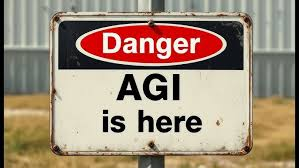

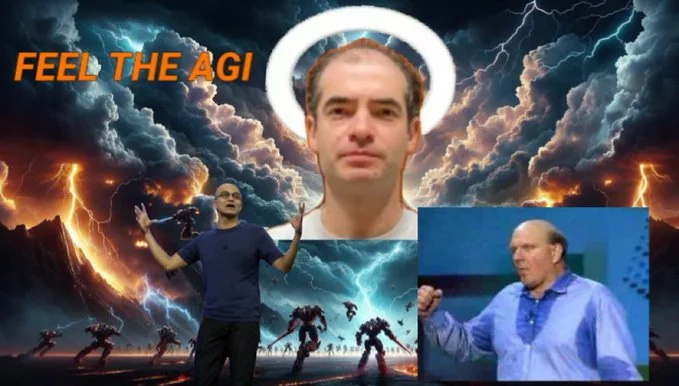

### **Train Additional Model Variants**

In [ ]:
for model_id in ['openai/whisper-large-v3-turbo', 'openai/whisper-small-v2']:
    print(f"Model: {model_id}")

    models = []
    fit_results = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.float32

    # Train
    for i, (train_index, valid_index) in enumerate(splitter.split(train_df, train_df['label'])):
        print(f"Split: {i + 1}", end="\n\n")

        train_audio_paths_split, train_labels_split = train_df['audio_path'].values[train_index], train_df['label'].values[train_index]
        valid_audio_paths_split, valid_labels_split = train_df['audio_path'].values[valid_index], train_df['label'].values[valid_index]

        train_dataset = AudioClassificationDataset(train_audio_paths_split, train_labels_split)
        valid_dataset = AudioClassificationDataset(valid_audio_paths_split, valid_labels_split)

        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            num_workers=num_workers, 
            shuffle=True, 
            drop_last=True,
            pin_memory=True
        )
        valid_loader = DataLoader(
            valid_dataset, 
            batch_size=batch_size, 
            num_workers=num_workers, 
            shuffle=False, 
            drop_last=False,
            pin_memory=True
        )

        model = AudioClassificationModel()
        model.to(device=device, dtype=dtype)
        optimizer = torch.optim.Adam([
            {'params': model.encoder.parameters(), 'lr': encoder_lr},
            {'params': model.head.parameters(), 'lr': head_lr}
        ])
        
        fit_result = {
            'train_losses': [],
            'train_f1': [],
            'valid_losses': [],
            'valid_f1': []
        }

        for epoch in range(1, num_epochs + 1):
            # === TRAIN ===
            model.train()
            train_losses = []
            all_train_preds, all_train_targets = [], []
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
            
            for batch in progress_bar:
                input_features = batch['input_features'].to(device=device, dtype=dtype)
                labels = batch['labels'].to(device=device)

                optimizer.zero_grad()
                outputs = model(input_features, labels=labels)
                loss = outputs['loss']
                loss.backward()
                optimizer.step()

                preds = outputs['logits'].argmax(dim=1).detach().cpu().numpy()
                targets = labels.cpu().numpy()

                all_train_preds.extend(preds)
                all_train_targets.extend(targets)
                train_losses.append(loss.item())

                progress_bar.set_postfix(loss=loss.item())

            train_loss = sum(train_losses) / len(train_losses)
            train_f1 = f1_score(all_train_targets, all_train_preds, average='macro')
            fit_result['train_losses'].append(train_loss)
            fit_result['train_f1'].append(train_f1)
            print(f"Train loss: {train_loss:.4f} | F1 (macro): {train_f1:.4f}")

            # === VALID ===
            model.eval()
            valid_losses = []
            all_valid_preds, all_valid_targets = [], []

            progress_bar = tqdm(valid_loader, desc=f"Epoch {epoch} [Valid]")
            with torch.no_grad():
                for batch in progress_bar:
                    input_features = batch['input_features'].to(device=device, dtype=dtype)
                    labels = batch['labels'].to(device=device)

                    outputs = model(input_features, labels=labels)
                    loss = outputs['loss']

                    preds = outputs['logits'].argmax(dim=1).detach().cpu().numpy()
                    targets = labels.cpu().numpy()

                    all_valid_preds.extend(preds)
                    all_valid_targets.extend(targets)
                    valid_losses.append(loss.item())

                    progress_bar.set_postfix(loss=loss.item())

            valid_loss = sum(valid_losses) / len(valid_losses)
            valid_f1 = f1_score(all_valid_targets, all_valid_preds, average='macro')

            fit_result['valid_losses'].append(valid_loss)
            fit_result['valid_f1'].append(valid_f1)

            print(f"Valid loss: {valid_loss:.4f} | F1 (macro): {valid_f1:.4f}\n")

        fit_results.append(fit_result)
        models.append(model)
        
        path = f'models/split_{i + 1}_{model_id}.pt'
        torch.save(model.state_dict(), path)
        break

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.float32
    model = AudioClassificationModel()
    model.to(device=device, dtype=dtype)
    model.load_state_dict(torch.load(f'models/split_1_{model_id}.pt', map_location=device))
    model.to(device, dtype=dtype)
    model.eval();

    all_preds = []
    all_ids = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Inference"):
            input_features = batch['input_features'].to(device=device, dtype=dtype)
            outputs = model(input_features)
            # DataParallel: берем mean по GPU, если есть
            logits = outputs['logits']
            preds = logits.argmax(dim=1).detach().cpu().numpy()

            all_preds.extend(preds)
            all_ids.extend(batch['id'])
    
    submission = pd.DataFrame({
        'id': all_ids,
        'label': all_preds
    })

    submission.to_csv(f'approach_3_{model_id}.csv', index=False)

## **Ensemble Blending via Majority Voting**

In [ ]:
sub_1 = pd.read_csv('approach_3_openai/whisper-medium.csv')
sub_2 = pd.read_csv('approach_3_openai/whisper-large-v3-turbo.csv')
sub_3 = pd.read_csv('approach_3_openai/whisper-small-v2.csv')

In [ ]:
sub = sub_1.drop(columns=['label']).copy()
sub['label1'] = sub_1['label']
sub['label2'] = sub_2['label']
sub['label3'] = sub_3['label']

In [ ]:
preds = []

for i, row in sub.iterrows():
    votes = [row['label1'], row['label2'], row['label3']]
    final_label = max(set(votes), key=votes.count)  # majority vote
    preds.append(final_label)

sub = pd.DataFrame({
    'id': sub['id'],
    'label': preds
})
sub.to_csv('approach_4_blended.csv', index=False)

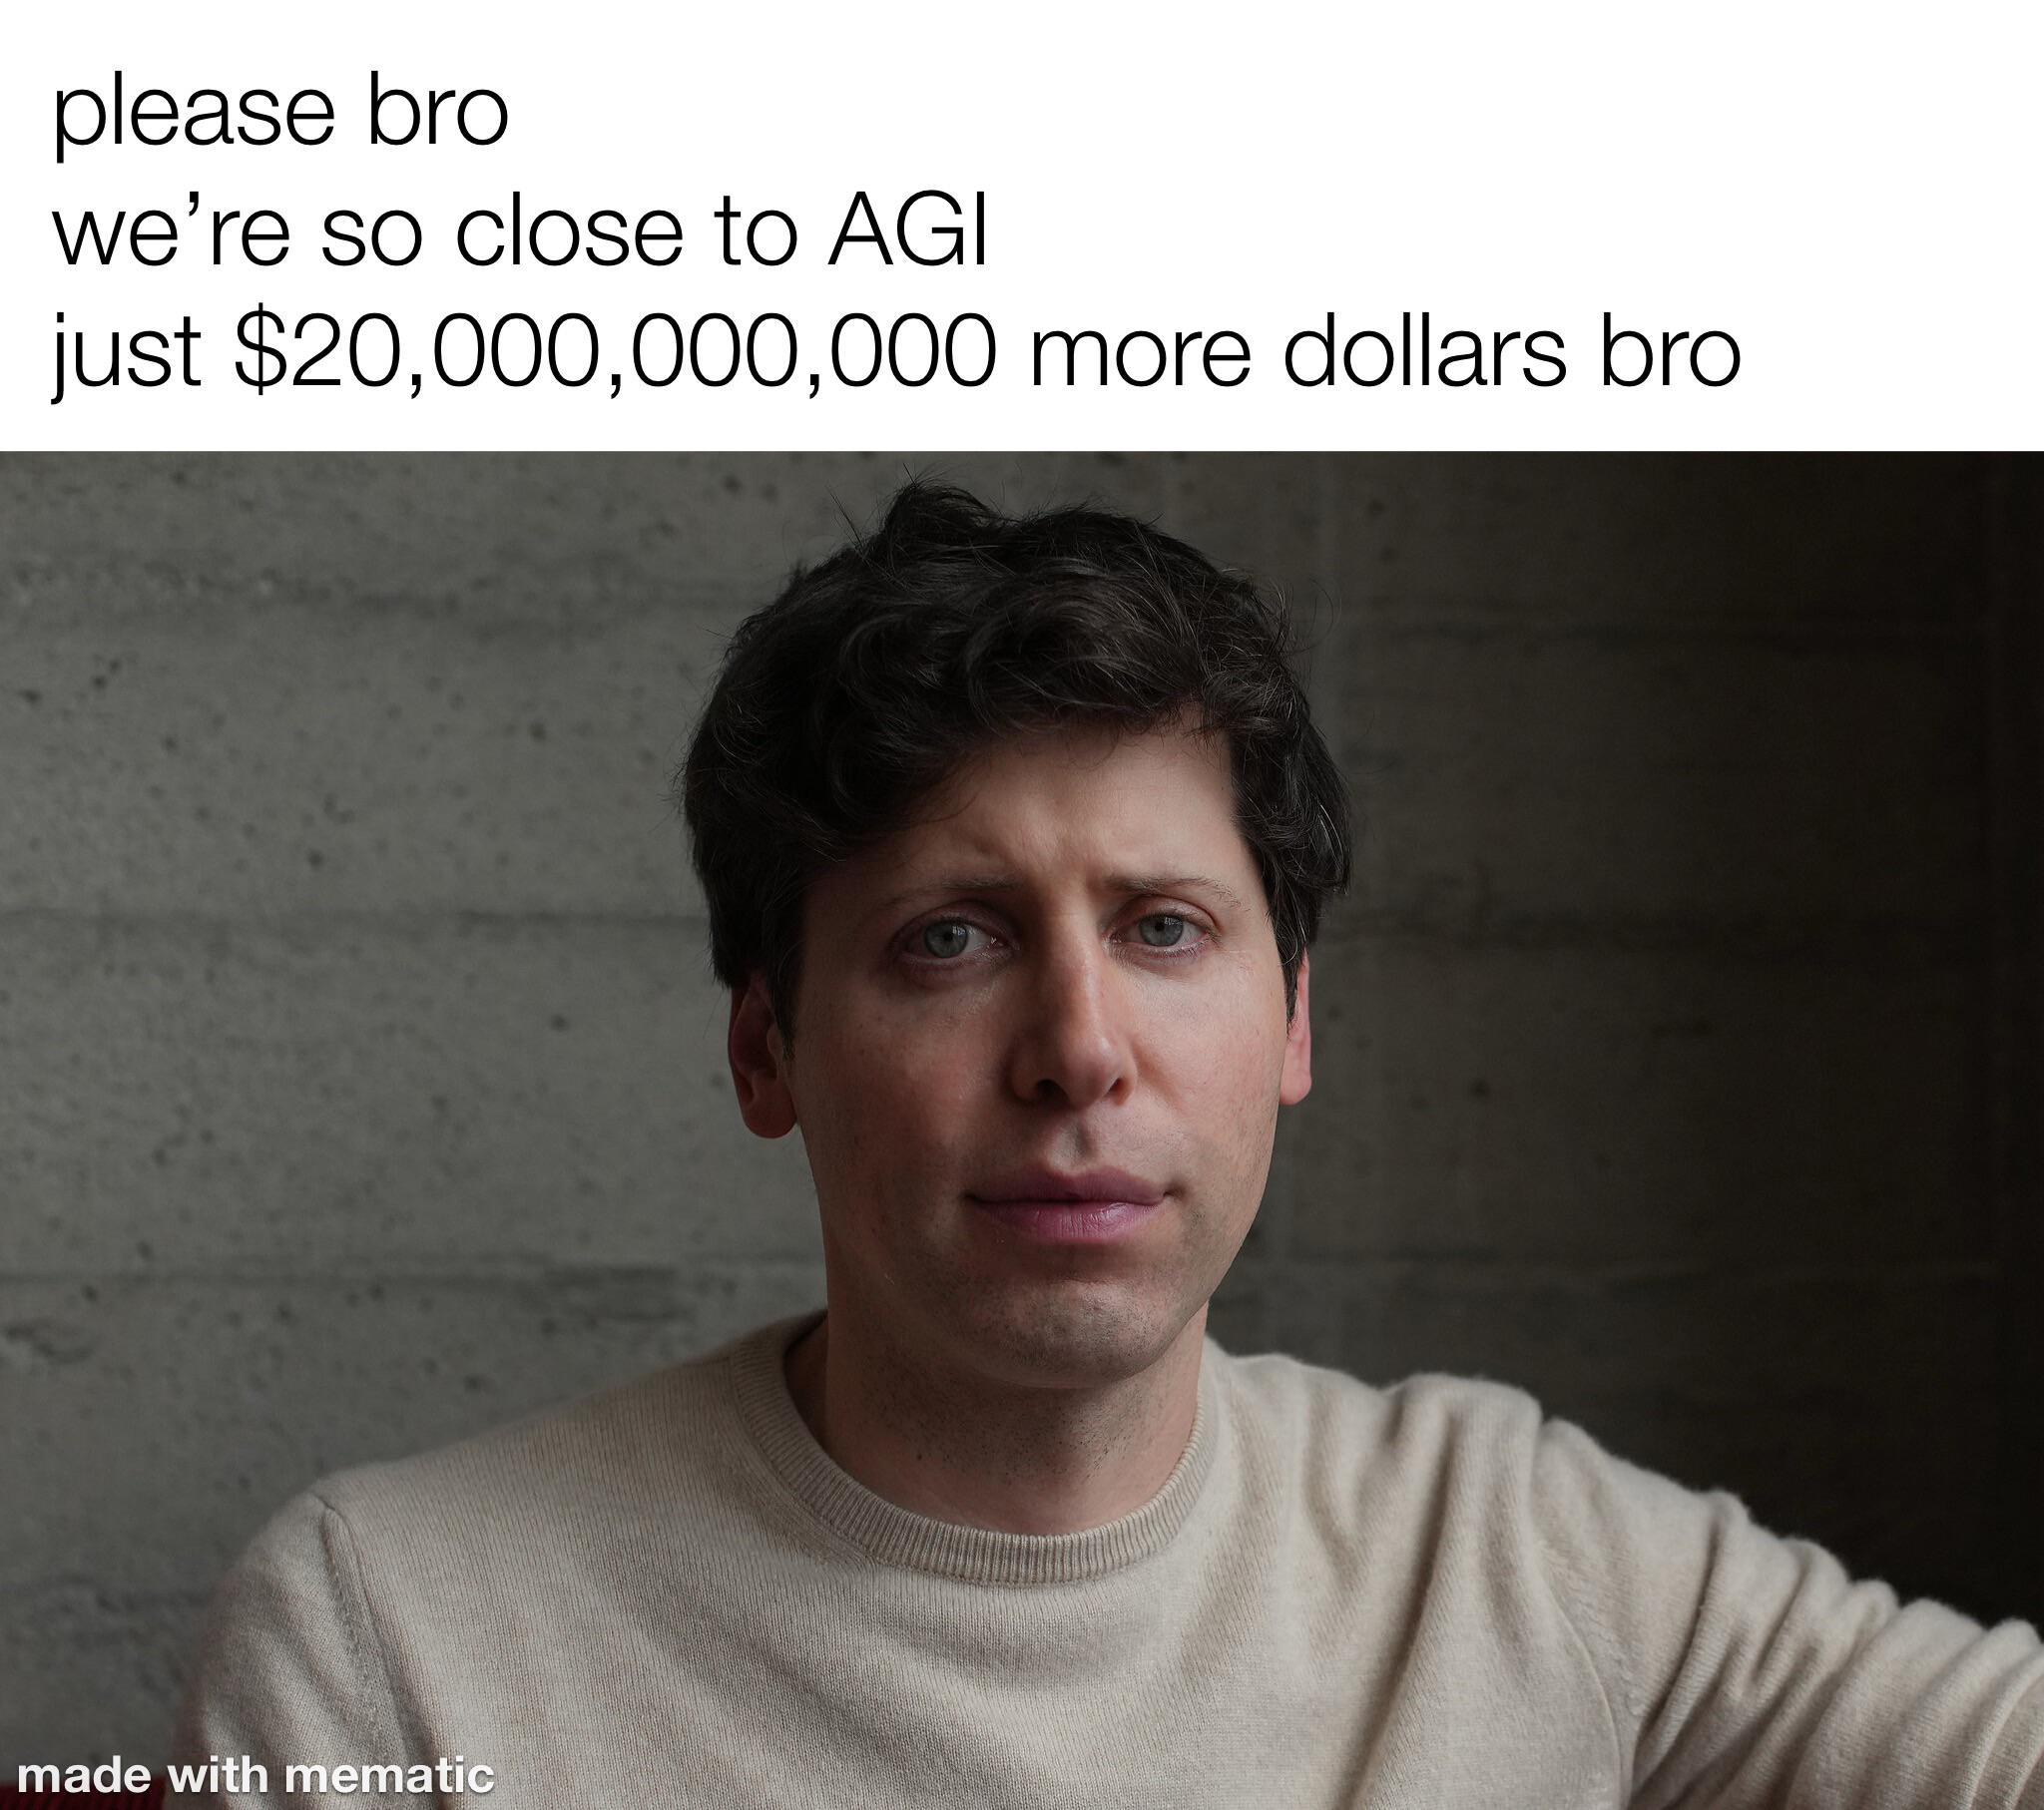